In [6]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [10]:
df = pd.read_feather('./datasets/coinbase_hour_candles/LTC_USD.feather')
df

,time,open,high,low,close,volume
0,2016-08-17 21:00:00+00:00,2.0,2.0,2.0,2.0,0.635381
1,2016-08-17 22:00:00+00:00,2.0,2.0,2.0,2.0,0.000000
2,2016-08-17 23:00:00+00:00,2.0,2.0,2.0,2.0,0.000000
3,2016-08-18 00:00:00+00:00,2.0,2.0,2.0,2.0,0.000000
4,2016-08-18 01:00:00+00:00,2.0,2.0,2.0,2.0,0.000000
...,...,...,...,...,...,...
33794,2020-06-25 23:00:00+00:00,42.0,42.0,42.0,42.0,162879.064000
33795,2020-06-26 00:00:00+00:00,42.0,42.0,42.0,42.0,26443.898680
33796,2020-06-26 01:00:00+00:00,42.0,42.0,42.0,42.0,122020.221137
33797,2020-06-26 02:00:00+00:00,42.0,42.0,42.0,42.0,81724.132924


<AxesSubplot:xlabel='time', ylabel='close'>

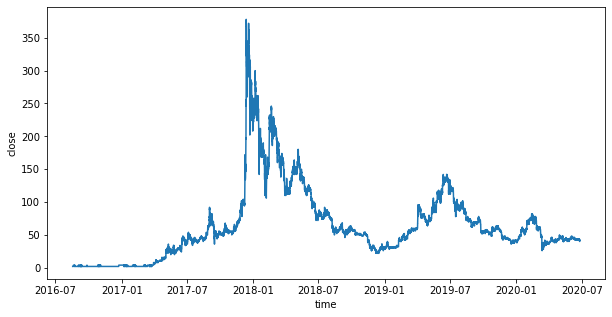

In [11]:
plt.figure(figsize=(10, 5))
sb.lineplot(data=df, x=df.time, y=df.close)